In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from scipy.special import expit  # sigmoid
import pandas as pd
import numpy as np
import random
from scipy.stats import truncnorm
import numpy as np
import pandas as pd
import joblib

<h1>Dataset Generation

In [2]:
def generate_data(n_per_class=1000, seed=42):
    np.random.seed(seed)
    random.seed(seed)

# --- University definitions (difficulty on a 0–10 scale) ---
    universities = {
        'FAST':    {'difficulty': 7, 'fields': ['CS']},
        'NUST':    {'difficulty': 8, 'fields': ['CS', 'Engineering', 'Medicine']},
        'UET':     {'difficulty': 6, 'fields': ['Engineering']},
        'COMSAT': {'difficulty': 5, 'fields': ['CS', 'Business']},
        'GIKI':    {'difficulty': 9, 'fields': ['Engineering', 'CS']}
    }

    fields  = ['CS', 'Engineering', 'Medicine', 'Business']
    regions = ['GB', 'Punjab', 'Sindh', 'KPK', 'Balochistan']

    # how much each subject “counts” for each field
    field_weights = {
        'CS':          {'math': 0.50, 'physics': 0.30, 'english': 0.20},
        'Engineering': {'math': 0.40, 'physics': 0.40, 'english': 0.20},
        'Medicine':    {'math': 0.30, 'physics': 0.40, 'english': 0.30},
        'Business':    {'math': 0.35, 'physics': 0.25, 'english': 0.40},
    }

    def calculate_weighted_average(field, math, physics, english):
        w = field_weights[field]
        return math*w['math'] + physics*w['physics'] + english*w['english']

    def student_field_tendency(field):
        # baseline strengths
        return {
            'CS':          {'math': 85, 'physics': 35, 'english': 20},
            'Engineering': {'math': 80, 'physics': 50, 'english': 15},
            'Medicine':    {'math': 65, 'physics': 45, 'english': 32},
            'Business':    {'math': 55, 'physics': 30, 'english': 35},
        }[field]

    def generate_marks(base, boost, max_score):
        """Truncated normal around (base+boost), clipped [35%*max, max]."""
        lower, upper = 0.35*max_score, max_score
        mean, sd = base+boost, 10
        a, b = (lower-mean)/sd, (upper-mean)/sd
        return round(truncnorm.rvs(a, b, loc=mean, scale=sd), 1)

    def generate_time_pct():
        """
        Returns a fraction of allotted time: N(1.0, 0.1) clipped [0.4,1.0].
        """
        return float(np.clip(np.random.normal(1.0, 0.1), 0.4, 1.0))

    # Admission‐prob formula
    def calculate_p(avg, diff, attempts):
        base     = expit((avg - 60) * 0.04)
        diff_fac = 1 - diff/10
        boost    = attempts * 0.05
        raw      = base * (diff_fac + 0.6) + boost
        return float(np.clip(raw, 0.1, 0.95))



    # Targets & counters
    target_yes= n_per_class
    target_no = n_per_class
    yes_count = 0
    no_count = 0
    admit_ctr = {uni: 0 for uni in universities}
    
    MAX_PER_UNI = n_per_class/5

    data = []
    student_idx = 0
    iterations = 0

    while (yes_count < target_yes or no_count < target_no):
        iterations += 1

        # 1. Pick field & region
        field  = random.choice(fields)
        region = random.choice(regions)

        # 2. Simulate marks & avg
        base_tend = student_field_tendency(field)
        attempts  = random.randint(1,3)
        boost     = (attempts-1)*3

        phys = generate_marks(base_tend['physics'], boost, 60)
        math = generate_marks(base_tend['math'],     boost,100)
        eng  = generate_marks(base_tend['english'],  boost, 40)
        avg  = calculate_weighted_average(field, math, phys, eng)

        # 3. Which unis can they apply to?
        possibles = [
        u for u,info in universities.items()
        if field in info['fields'] and admit_ctr[u] < MAX_PER_UNI
        ]
        # if not possibles:
        #         print(">>>>>>>>>>>>>>>>>>>>>>>>here")
        #         print(f"Iteration: {iterations}, Yes: {yes_count}, No: {no_count}, Admit Counts: {admit_ctr}")
        #         continue

        choices = random.sample(possibles, k=min(3, len(possibles)))

        # 4. Do the admission draws
        passed = {}
        for u in choices:
            p = calculate_p(avg, universities[u]['difficulty'], attempts)
            if random.random() < p:
                passed[u] = p

        if passed:
            admit_uni = max(passed, key=passed.get)
            yes_count += 1
            admit_ctr[admit_uni] += 1
            status = 1
        elif no_count < target_no:
            no_count += 1
            admit_uni = 'None'
            status = 0
        else:
            print("<<<<<<<<here")
            continue
        choice_difficulties = [universities[c]['difficulty'] for c in choices]
        while len(choices) < 3:
            choices.append(None)
            choice_difficulties.append(None)

        # 5. Record & iterate
        student_idx += 1
        data.append({
            'student_id':                 f"ST{student_idx:05}",
            'physics_marks':              phys,
            'math_marks':                 math,
            'english_marks':              eng,
            'average_marks':              round(avg, 2),
            'time_physics_pct':           generate_time_pct(),
            'time_math_pct':              generate_time_pct(),
            'time_english_pct':           generate_time_pct(),
            'number_of_attempts':         attempts,
            'preferred_field':            field,            # <-- Added here
            'region_preference':          region,
            'university_choices':         choices,
            'admission_status':           status,
            'admitted_university':        admit_uni,
            'choice1_diff':               choice_difficulties[0],
            'choice2_diff':               choice_difficulties[1],
            'choice3_diff':               choice_difficulties[2],
            'university_difficulty_index': universities[admit_uni]['difficulty'] if admit_uni!='None' else None
        })

        if (yes_count + no_count) % 1000 == 0:
            print(f"Yes:{yes_count}  No:{no_count}  Total:{yes_count+no_count}")

    # Convert to DataFrame and save
    df = pd.DataFrame(data)
    base_threshold = 50
    for univ, idx in universities.items():
        df[f'perf_gap_{univ}'] = df['average_marks'] - base_threshold * idx['difficulty']
    df['phy_norm']  = df['physics_marks'] / 60
    df['math_norm'] = df['math_marks'] / 100
    df['eng_norm']  = df['english_marks'] / 40
    df[['choice1','choice2','choice3']] = pd.DataFrame(df['university_choices'].tolist(), index=df.index)
    df['eff_phy'] = df['time_physics_pct'] * df['phy_norm']
    df['eff_math'] = df['time_math_pct'] * df['math_norm']
    df['eff_eng'] = df['time_english_pct'] * df['eng_norm']
    df['attempt_x_diff'] = df['number_of_attempts'] * df['university_difficulty_index'].fillna(1)

    return df
# df.to_csv('realistic_student_data.csv', index=False)


In [6]:
df_model=generate_data(20000)

Yes:670  No:330  Total:1000
Yes:1329  No:671  Total:2000
Yes:2009  No:991  Total:3000
Yes:2682  No:1318  Total:4000
Yes:3317  No:1683  Total:5000
Yes:3961  No:2039  Total:6000
Yes:4619  No:2381  Total:7000
Yes:5272  No:2728  Total:8000
Yes:5933  No:3067  Total:9000
Yes:6579  No:3421  Total:10000
Yes:7260  No:3740  Total:11000
Yes:7939  No:4061  Total:12000
Yes:8596  No:4404  Total:13000
Yes:9244  No:4756  Total:14000
Yes:9913  No:5087  Total:15000
Yes:10580  No:5420  Total:16000
Yes:11233  No:5767  Total:17000
Yes:11753  No:6247  Total:18000
Yes:12289  No:6711  Total:19000
Yes:12823  No:7177  Total:20000
Yes:13358  No:7642  Total:21000
Yes:13806  No:8194  Total:22000
Yes:14193  No:8807  Total:23000
Yes:14578  No:9422  Total:24000
Yes:14947  No:10053  Total:25000
Yes:15353  No:10647  Total:26000
Yes:15720  No:11280  Total:27000
Yes:16036  No:11964  Total:28000
Yes:16308  No:12692  Total:29000
Yes:16591  No:13409  Total:30000
Yes:16872  No:14128  Total:31000
Yes:17158  No:14842  Total:32

<h1>Model Pipline 1 

In [7]:
universities = {
        'FAST':    {'difficulty': 7, 'fields': ['CS']},
        'NUST':    {'difficulty': 8, 'fields': ['CS', 'Engineering', 'Medicine']},
        'UET':     {'difficulty': 6, 'fields': ['Engineering']},
        'COMSAT': {'difficulty': 5, 'fields': ['CS', 'Business']},
        'GIKI':    {'difficulty': 9, 'fields': ['Engineering', 'CS']}
    }

In [ ]:


# Preprocessing pipeline
numeric_feats = [
    'average_marks','phy_norm','math_norm','eng_norm',
       'number_of_attempts','eff_phy','eff_math','eff_eng','attempt_x_diff','choice1_diff','choice2_diff','choice3_diff'
] + [f'perf_gap_{u}' for u in universities]
categorical_feats = ['preferred_field','choice1','choice2','choice3']

master_ct = ColumnTransformer([
    ('num', StandardScaler(),      numeric_feats),
    ('cat', OneHotEncoder(
                sparse_output=False,
                drop='first',
                handle_unknown='ignore'
            ), categorical_feats),
])

# Stage 1: Admission Prediction
X1 = df_model[numeric_feats+categorical_feats]
y1 = df_model['admission_status']
pipe1 = Pipeline([
    ('prep', master_ct),
    ('clf', RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,            
    min_samples_leaf=100,      
    max_features='sqrt',     
    oob_score=True,        
    class_weight="balanced",
    random_state=42,
    n_jobs = -1))
])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=42)

pipe1.fit(X_train, y_train)
print("Train Accuracy:", pipe1.score(X_train, y_train))
print("Test Accuracy:", pipe1.score(X_test, y_test))


Train Accuracy: 1.0
Test Accuracy: 1.0


<h1>Model Training for Pipline 1

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Get training and test performance to check for overfitting
train_accuracies = []
test_accuracies = []
cv_scores = []

print("=== Overfitting Check and Cross-Validation Scores ===")
for fold, (train_idx, test_idx) in enumerate(kf.split(X1, y1), 1):
    X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y1.iloc[train_idx], y1.iloc[test_idx]
    
    pipe1.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipe1.predict(X_train)
    y_test_pred = pipe1.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"\nFold {fold}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred, zero_division=0))

# Cross-validation accuracy using the entire dataset
cv_accuracy_scores = cross_val_score(pipe1, X1, y1, cv=kf, scoring='accuracy', n_jobs=-1)

print("\n=== Summary ===")
print("Average Train Accuracy:", sum(train_accuracies) / len(train_accuracies))
print("Average Test Accuracy:", sum(test_accuracies) / len(test_accuracies))
print("Cross-Validation Accuracy Scores:", cv_accuracy_scores)
print("Mean CV Accuracy:", cv_accuracy_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_accuracy_scores.std())


=== Overfitting Check and Cross-Validation Scores ===

Fold 1
Train Accuracy: 1.0000
Test Accuracy:  1.0000
Confusion Matrix:
 [[4000    0]
 [   0 4000]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00      4000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


Fold 2
Train Accuracy: 1.0000
Test Accuracy:  1.0000
Confusion Matrix:
 [[4000    0]
 [   0 4000]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00      4000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


Fold 3
Train Accuracy: 1.0000
Test Accuracy:  1.0000
Confusion Matrix:
 [[4000    0]
 [   0

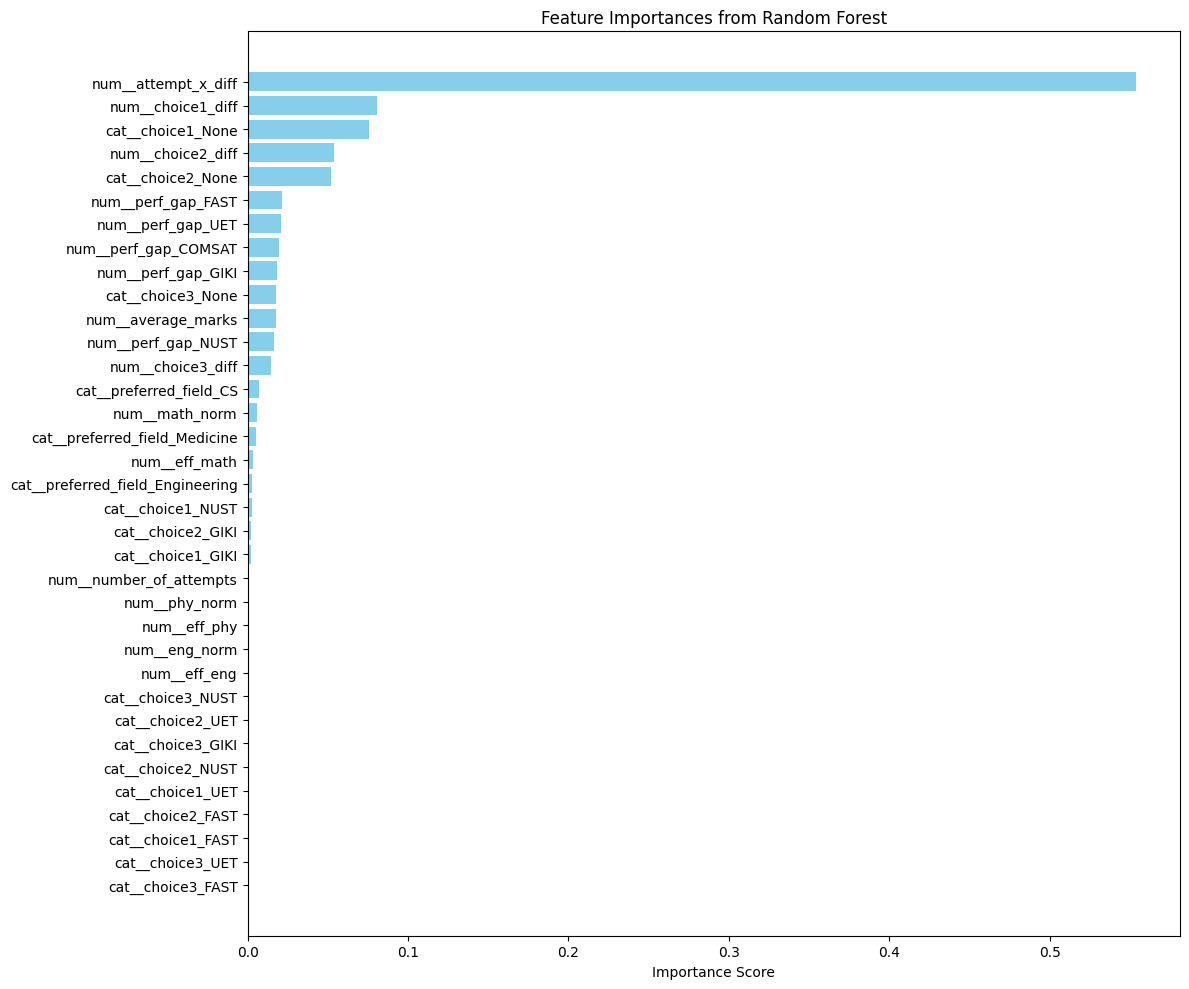

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Get the fitted preprocessor and classifier from the pipeline
preprocessor = pipe1.named_steps['prep']
model = pipe1.named_steps['clf']

# Get all transformed feature names
all_feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the Random Forest model
importances = model.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_feature_names = all_feature_names[indices]
sorted_importances = importances[indices]

# Plot feature importance
plt.figure(figsize=(12, 10))
plt.title("Feature Importances from Random Forest")
plt.barh(sorted_feature_names[::-1], sorted_importances[::-1], color="skyblue")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


<h1>Pipline 2

In [ ]:

# Stage 2: University Assignment
df_adm = df_model[df_model['admission_status']==1].copy()
df_adm=df_adm.drop(columns=['admission_status'])
X2 = df_adm[numeric_feats+categorical_feats]
y2 = df_adm['admitted_university']

pipe2 = Pipeline([
    ('prep', master_ct),
    ('clf', RandomForestClassifier(    
    n_estimators=1000,
    max_depth=10,            
    min_samples_leaf=200,      
    max_features='sqrt',     
    oob_score=True,        
    class_weight="balanced",
    random_state=42,
     n_jobs = -1))
])




In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=42)

pipe2.fit(X_train, y_train)
print("Train Accuracy:", pipe2.score(X_train, y_train))
print("Test Accuracy:", pipe2.score(X_test, y_test))


Train Accuracy: 0.7992857142857143
Test Accuracy: 0.794


<h1>Cross-Validation

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Get training and test performance to check for overfitting
train_accuracies = []
test_accuracies = []
cv_scores = []

print("=== Overfitting Check and Cross-Validation Scores ===")
for fold, (train_idx, test_idx) in enumerate(kf.split(X2, y2), 1):
    X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
    y_train, y_test = y2.iloc[train_idx], y2.iloc[test_idx]
    
    pipe2.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipe2.predict(X_train)
    y_test_pred = pipe2.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"\nFold {fold}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred, zero_division=0))

# Cross-validation accuracy using the entire dataset
cv_accuracy_scores = cross_val_score(pipe1, X2, y2, cv=kf, scoring='accuracy', n_jobs=-1)

print("\n=== Summary ===")
print("Average Train Accuracy:", sum(train_accuracies) / len(train_accuracies))
print("Average Test Accuracy:", sum(test_accuracies) / len(test_accuracies))
print("Cross-Validation Accuracy Scores:", cv_accuracy_scores)
print("Mean CV Accuracy:", cv_accuracy_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_accuracy_scores.std())


=== Overfitting Check and Cross-Validation Scores ===

Fold 1
Train Accuracy: 0.7913
Test Accuracy:  0.7933
Confusion Matrix:
 [[799   1   0   0   0]
 [ 63 737   0   0   0]
 [ 23 219 404   1 153]
 [ 50 101   0 433 216]
 [  0   0   0   0 800]]
              precision    recall  f1-score   support

      COMSAT       0.85      1.00      0.92       800
        FAST       0.70      0.92      0.79       800
        GIKI       1.00      0.51      0.67       800
        NUST       1.00      0.54      0.70       800
         UET       0.68      1.00      0.81       800

    accuracy                           0.79      4000
   macro avg       0.85      0.79      0.78      4000
weighted avg       0.85      0.79      0.78      4000


Fold 2
Train Accuracy: 0.7936
Test Accuracy:  0.7940
Confusion Matrix:
 [[797   3   0   0   0]
 [ 58 742   0   0   0]
 [ 26 207 398   0 169]
 [ 39 101   0 439 221]
 [  0   0   0   0 800]]
              precision    recall  f1-score   support

      COMSAT       0.87 

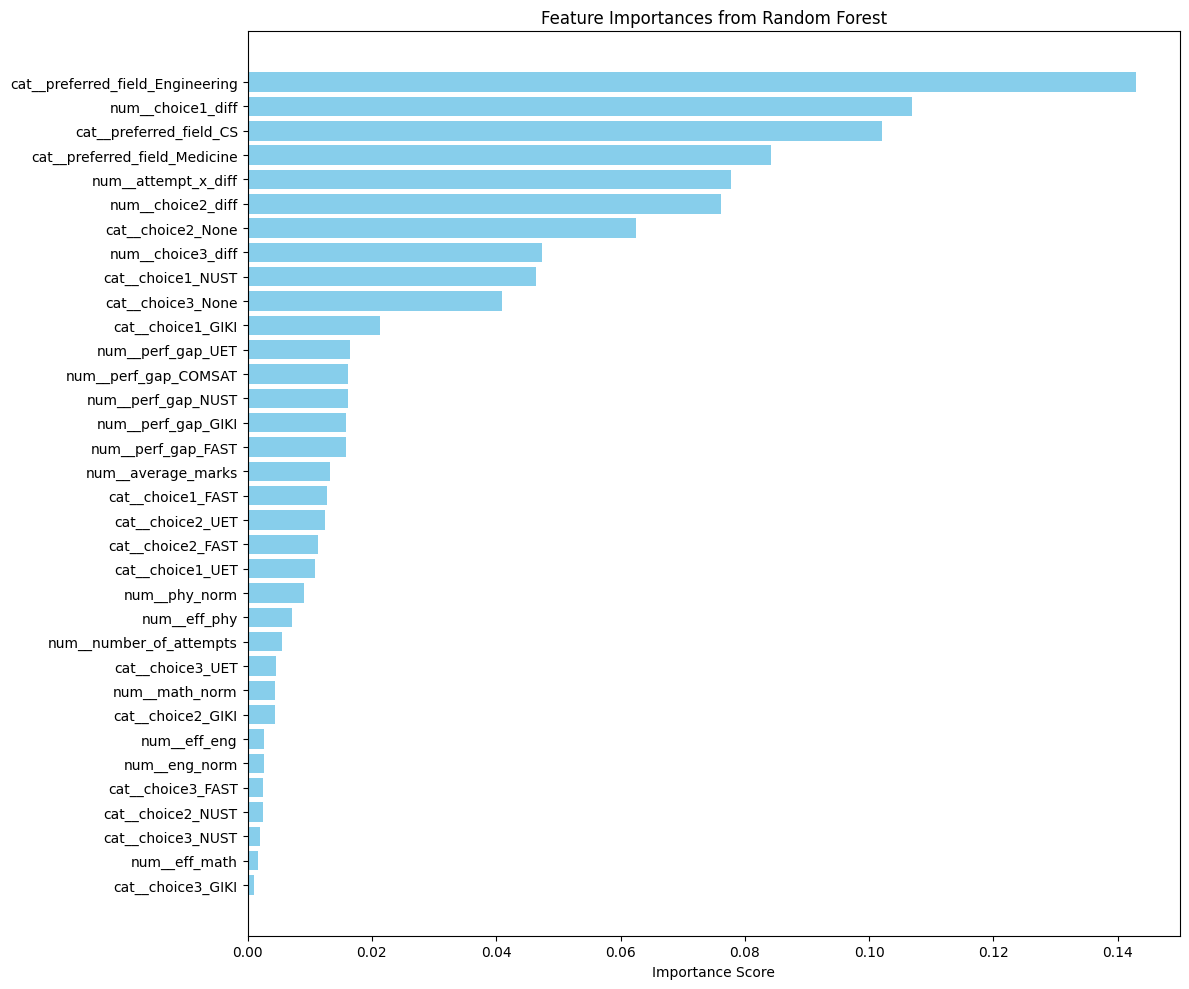

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Get the fitted preprocessor and classifier from the pipeline
preprocessor = pipe2.named_steps['prep']
model = pipe2.named_steps['clf']

# Get all transformed feature names
all_feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the Random Forest model
importances = model.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_feature_names = all_feature_names[indices]
sorted_importances = importances[indices]

# Plot feature importance
plt.figure(figsize=(12, 10))
plt.title("Feature Importances from Random Forest")
plt.barh(sorted_feature_names[::-1], sorted_importances[::-1], color="skyblue")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [ ]:
joblib.dump(pipe1, 'stage1_pipeline.pkl')
joblib.dump(pipe2, 'stage2_pipeline.pkl')

<h1>Model 1 is to predict the status of admission and second model check from the admitted once in which university they got into